# Metodología de Control de Calidad e Imputación de Datos de Series de Precipitación In Situ

## Objetivo
Esta metodología tiene como finalidad establecer un proceso robusto para la imputación de datos de precipitación in situ, utilizando técnicas modernas de Big Data y Machine Learning, complementadas con datos satelitales y bases de datos climáticas globales (como CHIRPS, ERA5, entre otras).

## 1. Preprocesamiento y Estandarización de Datos
Antes de aplicar cualquier proceso de control de calidad o imputación, es fundamental garantizar la correcta estructuración de los datos brutos o primarios.

La estructura base de una serie de datos estandarizada será:

| Index       | value |
|-------------|--------|
| 2020-01-01  | 2.53   |

- Index: tipo datetime, correspondiente a la fecha y hora de la observación.

- value: valor numérico registrado (precipitación en mm, por ejemplo).

Esta estructura debe representarse como una `pandas.Series` o un `pandas.DataFrame`, con índice tipo `datetime`.

## 2. Estructura de Control de Calidad
A partir de la serie estandarizada, se genera una estructura de control de calidad que enriquece la serie con metadatos asociados al resultado de las pruebas de calidad:

| Index       | value | qf | dp    |
|-------------|-------|----|-------|
| 2020-01-01  | 2.53  | 1  | 22358 |

- **qf (Quality Flag)**: código numérico que indica el resultado de una o varias pruebas de calidad.

- **dp (Descriptor de Proceso)**: identificador del proceso o técnica aplicada (detección, interpolación, imputación, etc.).

> ⚠️ La preservación de los datos originales es una prioridad. Las modificaciones solo deben aplicarse cuando la prueba indique una necesidad clara y bien justificada.

## 3. Pruebas de Control de Calidad
### 3.1. Consistencia Temporal
Una serie temporal debe tener frecuencia de muestreo constante. Esto significa que cada paso de tiempo entre observaciones debe ser homogéneo (e.g., diaria, horaria).

Proceso:
- Se analiza la frecuencia de muestreo mediante pandas.infer_freq o análisis de diferencias del índice.

- Si se detectan huecos en la serie (días u horas faltantes), se reindexa la serie para completar la malla temporal esperada.

    `df = df.asfreq('D')  # ejemplo para series diarias`
- A los puntos sin datos se les asigna un valor por defecto de -99999, conforme a estándares internacionales como los del IODE (International Oceanographic Data and Information Exchange).
    `df['value'].fillna(-99999, inplace=True)`

### 3.2. Otras Pruebas Básicas
- Rango Físico Aceptable: verifica que los valores estén dentro del rango físico o esperable (e.g., precipitación no puede ser negativa).

- Detección de valores extremos/anómalos: puede utilizarse el IQR, desviaciones estándar, o algoritmos robustos como Isolation Forest.

- Duplicados temporales: detección y resolución de registros con el mismo timestamp.

- Coherencia contextual: análisis de coherencia con estaciones vecinas o datos satelitales.

## 4. Imputación de Datos Faltantes
Una vez aplicada la batería de pruebas de calidad y etiquetados los valores anómalos o faltantes, se procede con la imputación de datos.

### 4.1. Fuentes de Información para la Imputación
- Estaciones vecinas (in situ).

- Datos satelitales (e.g., CHIRPS, GPM).

- Reanálisis climáticos (e.g., ERA5).

- Modelos estadísticos o de machine learning.

### 4.2. Técnicas de Imputación
- Interpolación temporal: lineal, spline, polinómica.

- K-Nearest Neighbors (KNN).

- Modelos de regresión multivariable (MLR).

- Redes neuronales (RNN, LSTM) para imputaciones complejas.

- Random Forest para variables con relaciones no lineales.

- La técnica aplicada se documenta en la columna dp, permitiendo rastrear el origen de cada dato imputado.

## 5. Estándares y Buenas Prácticas
- Trazabilidad: Toda modificación o imputación debe estar documentada y trazable.

- Conservación de Datos Originales: Mantener una copia sin modificar de la serie original.

- Reproducibilidad: Los scripts de calidad deben ser modulares y versionados.

- Evaluación Continua: Los algoritmos de imputación deben ser validados periódicamente frente a nuevas entradas de datos.

```
import pandas as pd

# Serie original
data = {'value': [2.53, 3.0, None, 2.1]}
index = pd.date_range(start='2020-01-01', periods=4, freq='D')
df = pd.DataFrame(data, index=index)

# Estructura de calidad
df['qf'] = [1, 1, 9, 1]  # 9 indica dato faltante
df['dp'] = [22358, 22358, 99999, 22358]
```
7. Resultados Esperados
- Series de precipitación limpias, consistentes, completas y trazables.

- Imputaciones realizadas con soporte técnico y científico.

- Alineación con estándares internacionales (WMO, IODE, etc.).

- Base sólida para análisis hidrometeorológicos, climatológicos o de gestión del recurso hídrico.



# Serie (redmpomm) Somo

In [1]:
from api_somo import APIClient, fetch_qf 
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date": "2009-01-01",
    "end_date": "2023-12-31"
}

try:
    # 1. Solicitar y procesar los datos
    red_mpomm_serie, red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)

    # Asegurar que el índice es datetime
    if not pd.api.types.is_datetime64_any_dtype(red_mpomm_serie.index):
        red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index)

    if red_mpomm_serie.empty:
        raise ValueError("La serie histórica está vacía.")

    #logger.info(f"Serie histórica descargada correctamente. Columnas: {red_mpomm_serie.columns.tolist()}")

except Exception as e:
    logger.error(f"Error al obtener la serie histórica: {e}")
    red_mpomm_serie = pd.DataFrame()  # para evitar errores en siguientes pasos

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not red_mpomm_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3])] = np.nan
    red_mpomm_serie = red_mpomm_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(red_mpomm_serie.isnull().sum())

    # Mostrar primeras filas
    red_mpomm_serie

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.


Reporte de datos NaN por columna:
value    29765
dtype: int64


## Prerocesamiento serie redmpomm

En esta etapa se realiza un remuestreo de la serie a 3h ya que las series de apoyo que se utilizaran para el desarrollo de esta metodologia tienen una resolucion maxima de 3h, para esto tomamos una condicion en nustre serie la cual para ser sonsiderado el balor remuestreado debe contener mas del **80%** de los datos buenos, en el caso contrario dejara este espacio como un NaN
 

In [2]:
red_mpomm_serie

value
timestamp                 
2009-02-01 05:10:00    0.0
2009-02-01 05:20:00    0.0
2009-02-01 05:30:00    0.0
2009-02-01 05:40:00    0.0
2009-02-01 05:50:00    0.0
...                    ...
2023-01-01 04:10:00    0.0
2023-01-01 04:20:00    0.0
2023-01-01 04:30:00    0.0
2023-01-01 04:40:00    0.0
2023-01-01 04:50:00    0.0

[731807 rows x 1 columns]

Reporte de datos NaN y/o null en la serie actual: 
value    1848
dtype: int64 



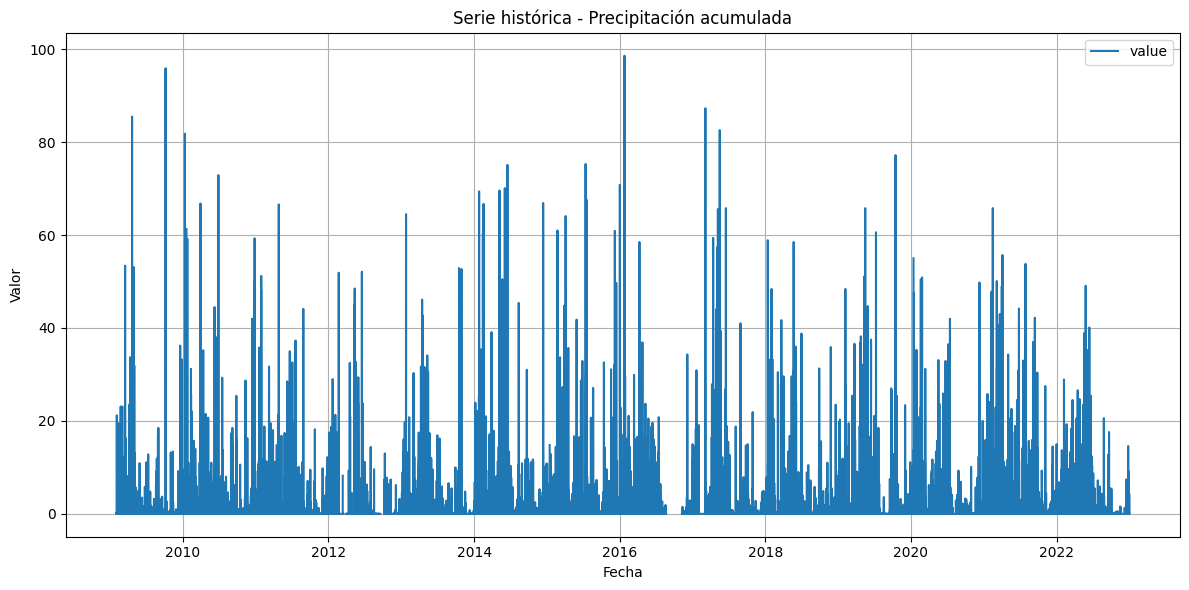

In [3]:
# Remuestreo condicional

# Función para eliminar grupos con más de un porcentaje de NaN
def custom_resample(group, nan_threshold=0.2):
    nan_ratio = group.isna().sum() / len(group)
    return group.sum() if nan_ratio < nan_threshold else np.nan

# Resampleo con diferentes períodos de agregación
red_mpomm_serie_3h = red_mpomm_serie.resample('3h').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print('Reporte de datos NaN y/o null en la serie actual: ')
print(red_mpomm_serie_3h.isnull().sum(),'\n')

lower_bound = 0
upper_bound = 100
# Reemplazar outliers con NaN
red_mpomm_serie_3h['value'] = red_mpomm_serie_3h['value'].where((red_mpomm_serie_3h['value'] >= lower_bound) & (red_mpomm_serie_3h['value'] <= upper_bound), np.nan)

# --- GRAFICAR ---
plt.figure(figsize=(12, 6))
plt.plot(red_mpomm_serie_3h, label=red_mpomm_serie_3h.columns[0])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie histórica - Precipitación acumulada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Serie MSWEB

Se realiza la obtencion de la matriz de datos de la base de datos global y se maneja los datos ausentes

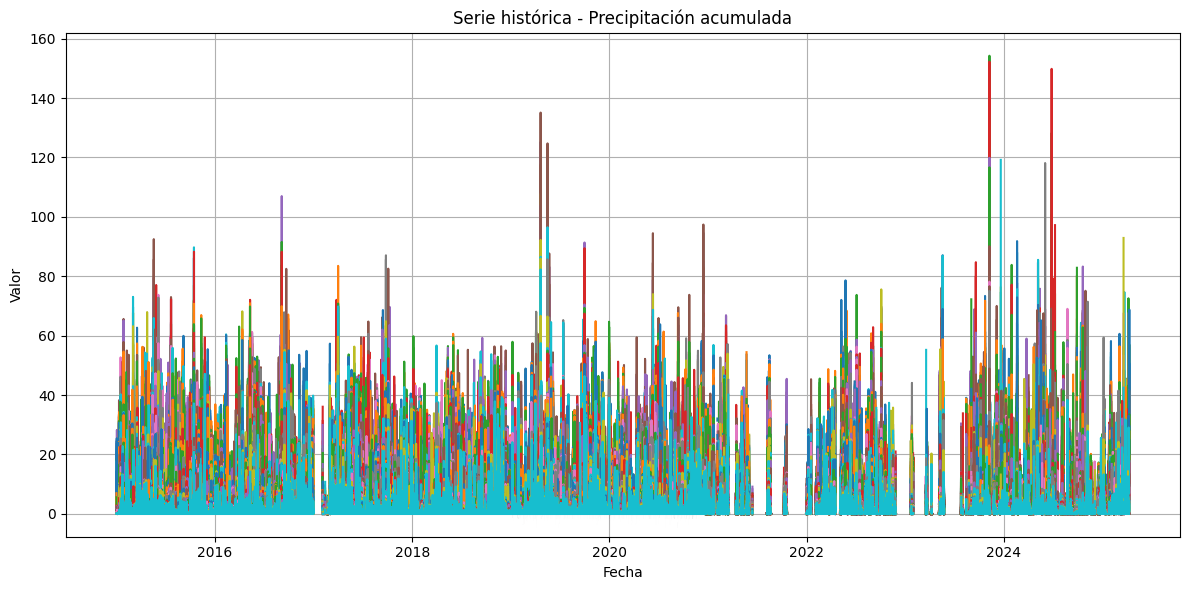

Reporte de datos NaN por columna:
lat_3.25_lon_-80.15    6392
lat_3.25_lon_-80.05    6392
lat_3.25_lon_-79.95    6392
lat_3.25_lon_-79.85    6392
lat_3.25_lon_-79.75    6392
                       ... 
lat_0.35_lon_-77.65    6392
lat_0.35_lon_-77.55    6392
lat_0.35_lon_-77.45    6392
lat_0.35_lon_-77.35    6392
lat_0.35_lon_-77.25    6392
Length: 900, dtype: int64


lat_3.25_lon_-80.15  lat_3.25_lon_-80.05  \
2015-01-01 00:00:00             1.000000             0.812500   
2015-01-01 03:00:00             0.375000             0.437500   
2015-01-01 06:00:00             0.250000             0.250000   
2015-01-01 09:00:00             0.312500             0.062500   
2015-01-01 12:00:00             0.750000             0.812500   
...                                  ...                  ...   
2025-04-10 03:00:00             1.130761             1.393022   
2025-04-10 06:00:00             1.195451             1.070038   
2025-04-10 09:00:00             0.167510             0.319612   
2025-04-10 12:00:00             2.754207             3.251528   
2025-04-10 15:00:00             1.619769             1.127022   

                     lat_3.25_lon_-79.95  lat_3.25_lon_-79.85  \
2015-01-01 00:00:00             0.437500             0.187500   
2015-01-01 03:00:00             0.250000             0.687500   
2015-01-01 06:00:00             0.687500             1.250000   
2015-01-01 09:00:00             0.062500             0.000000   
2015-01-01 12:00:00             0.812500             0.750000   
...                                  ...                  ...   
2025-04-10 03:00:00             1.356753             2.018488   
2025-04-10 06:00:00             1.045172             1.023405   
2025-04-10 09:00:00             0.306421             0.157334   
2025-04-10 12:00:00             4.775580             4.134336   
2025-04-10 15:00:00             1.109923             0.733727   

                     lat_3.25_lon_-79.75  lat_3.25_lon_-79.65  \
2015-01-01 00:00:00             0.187500             0.187500   
2015-01-01 03:00:00             1.062500             1.250000   
2015-01-01 06:00:00             1.250000             0.437500   
2015-01-01 09:00:00             0.000000             0.000000   
2015-01-01 12:00:00             0.750000             0.812500   
...                                  ...                  ...   
2025-04-10 03:00:00             1.988187             2.017505   
2025-04-10 06:00:00             1.029268             1.071232   
2025-04-10 09:00:00             0.157339             0.279948   
2025-04-10 12:00:00             3.978819             4.296918   
2025-04-10 15:00:00             0.756578             0.792208   

                     lat_3.25_lon_-79.55  lat_3.25_lon_-79.45  \
2015-01-01 00:00:00             0.187500             0.187500   
2015-01-01 03:00:00             1.500000             1.062500   
2015-01-01 06:00:00             0.750000             0.687500   
2015-01-01 09:00:00             0.000000             0.000000   
2015-01-01 12:00:00             0.875000             0.875000   
...                                  ...                  ...   
2025-04-10 03:00:00             2.438898             2.401794   
2025-04-10 06:00:00             1.259671             1.392551   
2025-04-10 09:00:00             0.689413             0.689083   
2025-04-10 12:00:00             5.841646             7.203510   
2025-04-10 15:00:00             0.529317             0.516464   

                     lat_3.25_lon_-79.35  lat_3.25_lon_-79.25  ...  \
2015-01-01 00:00:00             0.187500             0.187500  ...   
2015-01-01 03:00:00             0.812500             0.750000  ...   
2015-01-01 06:00:00             0.687500             0.687500  ...   
2015-01-01 09:00:00             0.000000             0.000000  ...   
2015-01-01 12:00:00             0.812500             0.812500  ...   
...                                  ...                  ...  ...   
2025-04-10 03:00:00             2.480694             2.459767  ...   
2025-04-10 06:00:00             1.301603             1.140934  ...   
2025-04-10 09:00:00             1.050254             1.096370  ...   
2025-04-10 12:00:00            10.714794            10.262192  ...   
2025-04-10 15:00:00             0.997060             1.028062  ...   

                     lat_0.35_lon_-78.15  lat_0.35_lon_-

In [4]:
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
msweb_serie = pd.read_csv(
    r"E:\074-Diego Rengifo 2025\datasience\precipitacion\db\MSWEP-GloH2O\csv-3h\precipitacion tum radius(1.82011, -78.72871).csv",
    parse_dates=['dates'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='dates'        # establecer la columna como índice
)


# --- Preprocesamiento: Agregacion temporal ---
if not msweb_serie.empty:
    msweb_serie.index= pd.to_datetime(msweb_serie.index)

    # Paso 2: Crear una serie con índice completo con frecuencia cada 3 horas
    start = msweb_serie.index.min()
    end = msweb_serie.index.max()
    full_index = pd.date_range(start=start, end=end, freq='3h')

    # Paso 3: Reindexar para insertar NaN donde faltan datos
    msweb_serie_with_nans = msweb_serie.reindex(full_index)
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(msweb_serie_with_nans, label=msweb_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    plt.show()

    # Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(msweb_serie_with_nans.isnull().sum())
msweb_serie_with_nans



# Dataset

Se realiza la union de la informacion en un dataset, en este añadimos datos de la redmpomm y de la base de datos global, en las marcas de tiempo que coincidan, con el fin de unificar y procesar los datos de manera mas optima.


In [5]:
# Asegurarse de que el índice de todos los DataFrames sea datetime sin zona horaria
msweb_serie.index = pd.to_datetime(msweb_serie.index).tz_localize(None)
red_mpomm_serie_3h.index = pd.to_datetime(red_mpomm_serie_3h.index).tz_localize(None)

# Convertir la serie objetivo en DataFrame si no lo es
serie_red = red_mpomm_serie_3h[['value']].copy()

# Renombrar columnas de msweb_serie con un prefijo claro
msweb_renamed = msweb_serie.copy()
msweb_renamed.columns = [f'precipitation_{i+1}' for i in range(len(msweb_serie.columns))]

# Unir todo en un solo DataFrame usando concat (más eficiente que múltiples joins)
dataset = pd.concat([serie_red, msweb_renamed], axis=1)

# Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(dataset.isnull().sum())

# Mostrar primeras filas
print(dataset.head())


Reporte de datos NaN por columna:
value                 5606
precipitation_1      20783
precipitation_2      20783
precipitation_3      20783
precipitation_4      20783
                     ...  
precipitation_896    20783
precipitation_897    20783
precipitation_898    20783
precipitation_899    20783
precipitation_900    20783
Length: 901, dtype: int64
                     value  precipitation_1  precipitation_2  precipitation_3  \
2009-02-01 03:00:00    0.0              NaN              NaN              NaN   
2009-02-01 06:00:00    0.0              NaN              NaN              NaN   
2009-02-01 09:00:00    0.0              NaN              NaN              NaN   
2009-02-01 12:00:00    0.0              NaN              NaN              NaN   
2009-02-01 15:00:00    0.0              NaN              NaN              NaN   

                     precipitation_4  precipitation_5  precipitation_6  \
2009-02-01 03:00:00              NaN              NaN              NaN   
2009-02-

In [6]:
dataset.tail(10)

value  precipitation_1  precipitation_2  precipitation_3  \
2025-04-09 12:00:00    NaN     4.261383e-07     6.299079e-01         0.630486   
2025-04-09 15:00:00    NaN     7.809896e-06     4.257816e-02         0.041836   
2025-04-09 18:00:00    NaN     8.766830e-06     6.451155e-07         0.000005   
2025-04-09 21:00:00    NaN     3.654393e-06     9.942392e-06         0.000003   
2025-04-10 00:00:00    NaN     2.451924e-01     4.478035e-01         0.431365   
2025-04-10 03:00:00    NaN     1.130761e+00     1.393022e+00         1.356753   
2025-04-10 06:00:00    NaN     1.195451e+00     1.070038e+00         1.045172   
2025-04-10 09:00:00    NaN     1.675099e-01     3.196117e-01         0.306421   
2025-04-10 12:00:00    NaN     2.754207e+00     3.251528e+00         4.775580   
2025-04-10 15:00:00    NaN     1.619769e+00     1.127022e+00         1.109923   

                     precipitation_4  precipitation_5  precipitation_6  \
2025-04-09 12:00:00         1.221657         1.845786         1.998672   
2025-04-09 15:00:00         0.428221         0.429788         0.832581   
2025-04-09 18:00:00         0.000005         0.000003         0.045832   
2025-04-09 21:00:00         0.000004         0.000009         0.000002   
2025-04-10 00:00:00         0.459507         0.461728         0.475972   
2025-04-10 03:00:00         2.018488         1.988187         2.017505   
2025-04-10 06:00:00         1.023405         1.029268         1.071232   
2025-04-10 09:00:00         0.157334         0.157339         0.279948   
2025-04-10 12:00:00         4.134336         3.978819         4.296918   
2025-04-10 15:00:00         0.733727         0.756578         0.792208   

                     precipitation_7  precipitation_8  precipitation_9  ...  \
2025-04-09 12:00:00         2.244337         2.076625         1.832989  ...   
2025-04-09 15:00:00         1.256035         2.002580         2.403096  ...   
2025-04-09 18:00:00         0.042902         0.101522         0.033001  ...   
2025-04-09 21:00:00         0.000004         0.000002         0.040604  ...   
2025-04-10 00:00:00         0.664445         0.641921         0.434630  ...   
2025-04-10 03:00:00         2.438898         2.401794         2.480694  ...   
2025-04-10 06:00:00         1.259671         1.392551         1.301603  ...   
2025-04-10 09:00:00         0.689413         0.689083         1.050254  ...   
2025-04-10 12:00:00         5.841646         7.203510        10.714794  ...   
2025-04-10 15:00:00         0.529317         0.516464         0.997060  ...   

                     precipitation_891  precipitation_892  precipitation_893  \
2025-04-09 12:00:00           0.119650           0.024798           0.023907   
2025-04-09 15:00:00           1.088970           0.545727           0.523100   
2025-04-09 18:00:00           1.278894           0.350776           0.560323   
2025-04-09 21:00:00           0.669301           0.368956           0.346348   
2025-04-10 00:00:00           0.276471           0.031584           0.030987   
2025-04-10 03:00:00           0.101513           0.013108           0.012417   
2025-04-10 06:00:00           0.179258           0.090540           0.080943   
2025-04-10 09:00:00           0.065251           0.027925           0.027097   
2025-04-10 12:00:00           0.276474           0.034734           0.032115   
2025-04-10 15:00:00           1.956641           0.877857           0.876555   

                     precipitation_894  precipitation_895  precipitation_896  \
2025-04-09 12:00:00           0.194104           0.207653           0.178997   
2025-04-09 15:00:00           0.745300           0.788111           0.723194   
2025-04-09 18:00:00           0.844885           0.893712           0.791807   
2025-04-09 21:00:00           0.745301           0.788108           0.723198   
2025-04-10 00:00:00           0.297783           0.319680           0.279256   
2025-04-10 03:00:00           0.426083           0.455359           0.428206   
202

In [7]:
# Filtrar todas las columnas de precipitación (excluyendo la serie objetivo)
precip_cols = [col for col in dataset.columns if col.startswith('precipitation_')]

# Encontrar el primer índice donde al menos una columna de precipitación tiene un valor no nulo
non_null_mask = dataset[precip_cols].notnull().any(axis=1)
start_index = dataset[non_null_mask].index.min()
end_index = dataset.iloc[:, 0].last_valid_index()

# Filtrar el DataFrame desde ese índice en adelante
filtered_dataset = dataset.loc[start_index:end_index]

# Verificar resultado
print(f"Primer dato válido en al menos una columna de precipitación: {start_index}")
filtered_dataset


Primer dato válido en al menos una columna de precipitación: 2015-01-01 00:00:00


value  precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00    0.0           1.0000           0.8125           0.4375   
2015-01-01 03:00:00    0.0           0.3750           0.4375           0.2500   
2015-01-01 06:00:00    0.0           0.2500           0.2500           0.6875   
2015-01-01 09:00:00    0.2           0.3125           0.0625           0.0625   
2015-01-01 12:00:00    4.7           0.7500           0.8125           0.8125   
...                    ...              ...              ...              ...   
2022-12-31 15:00:00    2.0              NaN              NaN              NaN   
2022-12-31 18:00:00    0.1              NaN              NaN              NaN   
2022-12-31 21:00:00    0.0              NaN              NaN              NaN   
2023-01-01 00:00:00    0.0              NaN              NaN              NaN   
2023-01-01 03:00:00    0.0              NaN              NaN              NaN   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00           0.1875           0.1875           0.1875   
2015-01-01 03:00:00           0.6875           1.0625           1.2500   
2015-01-01 06:00:00           1.2500           1.2500           0.4375   
2015-01-01 09:00:00           0.0000           0.0000           0.0000   
2015-01-01 12:00:00           0.7500           0.7500           0.8125   
...                              ...              ...              ...   
2022-12-31 15:00:00              NaN              NaN              NaN   
2022-12-31 18:00:00              NaN              NaN              NaN   
2022-12-31 21:00:00              NaN              NaN              NaN   
2023-01-01 00:00:00              NaN              NaN              NaN   
2023-01-01 03:00:00              NaN              NaN              NaN   

                     precipitation_7  precipitation_8  precipitation_9  ...  \
2015-01-01 00:00:00           0.1875           0.1875           0.1875  ...   
2015-01-01 03:00:00           1.5000           1.0625           0.8125  ...   
2015-01-01 06:00:00           0.7500           0.6875           0.6875  ...   
2015-01-01 09:00:00           0.0000           0.0000           0.0000  ...   
2015-01-01 12:00:00           0.8750           0.8750           0.8125  ...   
...                              ...              ...              ...  ...   
2022-12-31 15:00:00              NaN              NaN              NaN  ...   
2022-12-31 18:00:00              NaN              NaN              NaN  ...   
2022-12-31 21:00:00              NaN              NaN              NaN  ...   
2023-01-01 00:00:00              NaN              NaN              NaN  ...   
2023-01-01 03:00:00              NaN              NaN              NaN  ...   

                     precipitation_891  precipitation_892  precipitation_893  \
2015-01-01 00:00:00                0.0                0.0                0.0   
2015-01-01 03:00:00                0.0                0.0                0.0   
2015-01-01 06:00:00                0.0                0.0                0.0   
2015-01-01 09:00:00                0.0                0.0                0.0   
2015-01-01 12:00:00                0.0                0.0                0.0   
...                                ...                ...                ...   
2022-12-31 15:00:00                NaN                NaN                NaN   
2022-12-31 18:00:00                NaN                NaN                NaN   
2022-12-31 21:00:00                NaN                NaN                NaN   
2023-01-01 00:00:00                NaN                NaN                NaN   
2023-01-01 03:00:00                NaN                NaN                NaN   

                     precipitation_894  precipitation_895  precipitation_896  \
2015-01-01 00:00:00                0.0                0.0                0.0   
2015-01-01 03:00:00                0.0                0.0                0.0   
2015-01-0

In [8]:
'''import numpy as np

# Copia del DataFrame original
df = filtered_dataset.copy()

# Aplicar IQR solo a columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Filtrar outliers usando IQR en todas las columnas numéricas
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print('limite inferior: ', lower_bound, ' limite superior: ', upper_bound)

    # Reemplazar outliers con NaN
    df[col] = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound), np.nan)

# Resultado: DataFrame con NaN en los valores fuera del rango intercuartílico
filtered_iqr_dataset = df
'''
filtered_iqr_dataset = filtered_dataset

In [9]:
filtered_iqr_dataset.describe()

value  precipitation_1  precipitation_2  precipitation_3  \
count  22514.000000     19874.000000     19874.000000     19874.000000   
mean       0.810651         0.833847         0.876252         0.874318   
std        3.947242         2.128434         2.222971         2.193745   
min        0.000000         0.000000         0.000000         0.000000   
25%        0.000000         0.002047         0.023236         0.024952   
50%        0.000000         0.187500         0.187500         0.187500   
75%        0.000000         0.716718         0.750000         0.750000   
max       98.600000        53.250000        59.500000        58.812500   

       precipitation_4  precipitation_5  precipitation_6  precipitation_7  \
count     19874.000000     19874.000000     19874.000000     19874.000000   
mean          0.958533         0.991333         1.033761         1.175019   
std           2.414138         2.539463         2.605222         2.896215   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.062500         0.062500         0.062500         0.062500   
50%           0.250000         0.250000         0.250000         0.286163   
75%           0.823516         0.874534         0.875000         1.062500   
max          55.125000        47.271719        49.437500        58.875000   

       precipitation_8  precipitation_9  ...  precipitation_891  \
count     19874.000000     19874.000000  ...       19874.000000   
mean          1.183846         1.286069  ...           0.284626   
std           3.015487         3.252336  ...           0.741679   
min           0.000000         0.000000  ...           0.000000   
25%           0.062500         0.062500  ...           0.000000   
50%           0.257016         0.312500  ...           0.056191   
75%           1.057458         1.125000  ...           0.210342   
max          69.802329        52.937500  ...          16.625000   

       precipitation_892  precipitation_893  precipitation_894  \
count       19874.000000       19874.000000       19874.000000   
mean            0.301996           0.301755           0.391115   
std             0.758889           0.759822           1.024552   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.062500           0.062500           0.062500   
75%             0.250000           0.250000           0.312500   
max            13.687500          13.312500          29.187500   

       precipitation_895  precipitation_896  precipitation_897  \
count       19874.000000       19874.000000       19874.000000   
mean            0.454816           0.480084           0.641888   
std             1.176819           1.269786           1.661259   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.062500           0.062500           0.098505   
75%             0.375000           0.375000           0.500000   
max            30.437500          31.562500          36.125000   

       precipitation_898  precipitation_899  precipitation_900  
count       19874.000000       19874.000000       19874.000000  
mean            0.814642           0.950683           1.041543  
std             2.084584           2.434646           2.559066  
min             0.000000           0.000000           0.000000  
25%             0.000000           0.000000           0.000000  
50%             0.125000           0.125000           0.187500  
75%             0.687500           0.812500           0.937500  
max            44.937500          59.625000          46.500000  

[8 rows x 901 columns]

# Grafica

In [10]:
'''import matplotlib.pyplot as plt

# Número total de subplots: 1 (redmpomm) + número de columnas de precipitación
n_plots = 1 + len(precip_cols)

# Crear los subplots
fig, axs = plt.subplots(n_plots, 1, figsize=(12, 3 * n_plots), sharex=True, sharey=True)

# Asegurarse de que axs sea iterable incluso si n_plots == 1
if n_plots == 1:
    axs = [axs]

# Graficar la serie objetivo (redmpomm)
axs[0].plot(filtered_dataset.index, filtered_dataset['value'], label='redmpomm')
axs[0].legend()

# Graficar cada columna de precipitación
for i, col in enumerate(precip_cols):
    axs[i + 1].plot(filtered_dataset.index, filtered_dataset[col], label=col)
    axs[i + 1].legend()

# Rotar las etiquetas del eje x
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()
'''

"import matplotlib.pyplot as plt\n\n# Número total de subplots: 1 (redmpomm) + número de columnas de precipitación\nn_plots = 1 + len(precip_cols)\n\n# Crear los subplots\nfig, axs = plt.subplots(n_plots, 1, figsize=(12, 3 * n_plots), sharex=True, sharey=True)\n\n# Asegurarse de que axs sea iterable incluso si n_plots == 1\nif n_plots == 1:\n    axs = [axs]\n\n# Graficar la serie objetivo (redmpomm)\naxs[0].plot(filtered_dataset.index, filtered_dataset['value'], label='redmpomm')\naxs[0].legend()\n\n# Graficar cada columna de precipitación\nfor i, col in enumerate(precip_cols):\n    axs[i + 1].plot(filtered_dataset.index, filtered_dataset[col], label=col)\n    axs[i + 1].legend()\n\n# Rotar las etiquetas del eje x\nplt.xticks(rotation='vertical')\nplt.tight_layout()\nplt.show()\n"

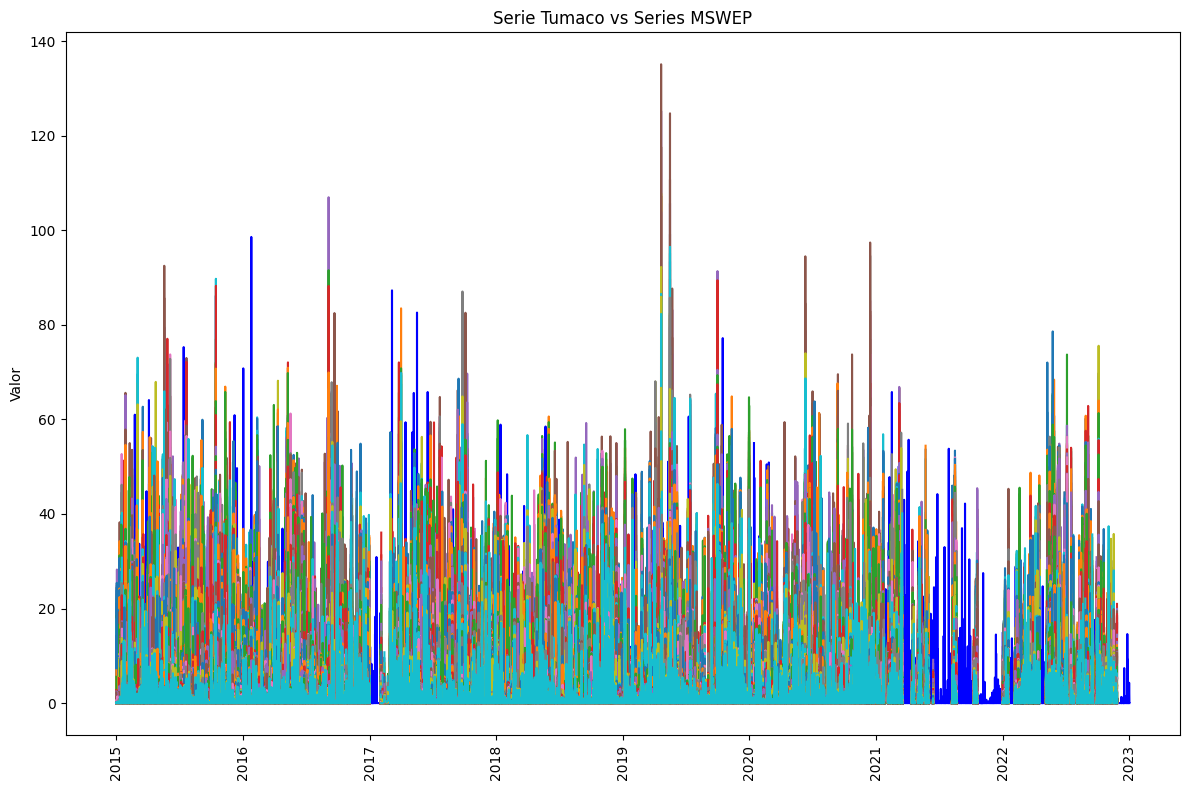

In [11]:
import matplotlib.pyplot as plt


# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8), sharex=True)

# Graficar la serie objetivo
ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label="Tumaco", color="blue")

# Graficar todas las columnas de precipitación con colores automáticos
for col in precip_cols:
    ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset[col], label=col)

# Configurar título y etiquetas
ax.set_title('Serie Tumaco vs Series MSWEP')
ax.set_ylabel('Valor')
#ax.legend(loc='upper left')

# Ajustar diseño y mostrar
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


In [12]:
import plotly.express as px
import calendar

#fig = px.box(filtered_dataset)
#fig.show()

In [13]:
'''import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = filtered_dataset.corr()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

# Título y ajustes
plt.title("Mapa de Correlación")
plt.tight_layout()
plt.show()'''


'import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calcular la matriz de correlación\ncorrelation_matrix = filtered_dataset.corr()\n\n# Crear el mapa de calor\nplt.figure(figsize=(12, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap=\'coolwarm\', vmin=-1, vmax=1, fmt=".2f")\n\n# Título y ajustes\nplt.title("Mapa de Correlación")\nplt.tight_layout()\nplt.show()'

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


In [15]:
precipNotNan = filtered_iqr_dataset.dropna()
print('Reporte de datos NaN por columna:')
print(precipNotNan.isnull().sum())
precipNotNan


Reporte de datos NaN por columna:
value                0
precipitation_1      0
precipitation_2      0
precipitation_3      0
precipitation_4      0
                    ..
precipitation_896    0
precipitation_897    0
precipitation_898    0
precipitation_899    0
precipitation_900    0
Length: 901, dtype: int64


value  precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00    0.0         1.000000         0.812500         0.437500   
2015-01-01 03:00:00    0.0         0.375000         0.437500         0.250000   
2015-01-01 06:00:00    0.0         0.250000         0.250000         0.687500   
2015-01-01 09:00:00    0.2         0.312500         0.062500         0.062500   
2015-01-01 12:00:00    4.7         0.750000         0.812500         0.812500   
...                    ...              ...              ...              ...   
2022-11-25 21:00:00    0.0         0.016920         0.019007         0.018900   
2022-11-26 03:00:00    0.0         0.019662         0.006580         0.006565   
2022-11-26 09:00:00    0.0         0.032139         0.042243         0.041898   
2022-11-26 12:00:00    0.0         0.016002         0.041127         0.040814   
2022-11-29 21:00:00    0.0         0.024004         0.039649         0.039328   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00         0.187500         0.187500         0.187500   
2015-01-01 03:00:00         0.687500         1.062500         1.250000   
2015-01-01 06:00:00         1.250000         1.250000         0.437500   
2015-01-01 09:00:00         0.000000         0.000000         0.000000   
2015-01-01 12:00:00         0.750000         0.750000         0.812500   
...                              ...              ...              ...   
2022-11-25 21:00:00         0.004469         0.004481         0.004517   
2022-11-26 03:00:00         0.005897         0.005918         0.005970   
2022-11-26 09:00:00         0.044485         0.044827         0.045546   
2022-11-26 12:00:00         0.084969         0.085854         0.087840   
2022-11-29 21:00:00         0.025691         0.025849         0.026143   

                     precipitation_7  precipitation_8  precipitation_9  ...  \
2015-01-01 00:00:00         0.187500         0.187500         0.187500  ...   
2015-01-01 03:00:00         1.500000         1.062500         0.812500  ...   
2015-01-01 06:00:00         0.750000         0.687500         0.687500  ...   
2015-01-01 09:00:00         0.000000         0.000000         0.000000  ...   
2015-01-01 12:00:00         0.875000         0.875000         0.812500  ...   
...                              ...              ...              ...  ...   
2022-11-25 21:00:00         0.005109         0.005087         0.005311  ...   
2022-11-26 03:00:00         0.015982         0.015835         0.001091  ...   
2022-11-26 09:00:00         0.025540         0.025246         0.014256  ...   
2022-11-26 12:00:00         0.143279         0.143912         0.139176  ...   
2022-11-29 21:00:00         0.055095         0.054176         0.018161  ...   

                     precipitation_891  precipitation_892  precipitation_893  \
2015-01-01 00:00:00           0.000000           0.000000           0.000000   
2015-01-01 03:00:00           0.000000           0.000000           0.000000   
2015-01-01 06:00:00           0.000000           0.000000           0.000000   
2015-01-01 09:00:00           0.000000           0.000000           0.000000   
2015-01-01 12:00:00           0.000000           0.000000           0.000000   
...                                ...                ...                ...   
2022-11-25 21:00:00           0.877691           0.628830           0.658874   
2022-11-26 03:00:00           0.028799           0.010813           0.010427   
2022-11-26 09:00:00           0.000124           0.012263           0.011733   
2022-11-26 12:00:00           0.002799           0.009658           0.008918   
2022-11-29 21:00:00           0.188982           0.087093           0.075255   

                     precipitation_894  precipitation_895  precipitation_896  \
2015-01-01 00:00:00           0.000000           0.000000           0.000000   
2015-01-01 03:00:00           0.000000           0.000000           0.000000   
2015-01-0

In [16]:
# Definir variables independientes (X) y dependiente (y)
xTrain = precipNotNan.drop(columns=['value'])
yTrain = precipNotNan['value'].values.flatten()
# Guardar columnas para usarlas después
columns_for_model = xTrain.columns

# Mostrar primeras 10 filas
print(xTrain.head(10))
print(yTrain[:10])

                     precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00           1.0000           0.8125           0.4375   
2015-01-01 03:00:00           0.3750           0.4375           0.2500   
2015-01-01 06:00:00           0.2500           0.2500           0.6875   
2015-01-01 09:00:00           0.3125           0.0625           0.0625   
2015-01-01 12:00:00           0.7500           0.8125           0.8125   
2015-01-01 15:00:00           0.1250           0.0000           0.0000   
2015-01-01 18:00:00           0.3125           0.0625           0.0000   
2015-01-01 21:00:00           0.6250           0.6875           0.6875   
2015-01-02 00:00:00           0.7500           0.3125           0.3125   
2015-01-02 03:00:00           0.8750           0.4375           0.4375   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00           0.1875           0.1875           0.1875   
2015-01-01 03:00:00           0.6875 

In [17]:
scaler = StandardScaler().fit(xTrain)
xTrainScaled = scaler.transform(xTrain)
print(xTrainScaled[:10])

[[ 0.07447345 -0.03256798 -0.20208967 ... -0.39473099 -0.39324394
  -0.40914105]
 [-0.21894447 -0.2007624  -0.28734703 ... -0.39473099 -0.39324394
  -0.40914105]
 [-0.27762805 -0.28485961 -0.08841318 ... -0.39473099 -0.39324394
  -0.40914105]
 ...
 [-0.1015773  -0.08863279 -0.08841318 ... -0.36449127 -0.39324394
  -0.40914105]
 [-0.04289372 -0.25682721 -0.25892791 ... -0.39473099 -0.39324394
  -0.40914105]
 [ 0.01578986 -0.2007624  -0.20208967 ... -0.39473099 -0.39324394
  -0.40914105]]


In [18]:
#check scaler
print(xTrainScaled.mean(axis=0))
print(xTrainScaled.std(axis=0))

[-1.79392233e-17 -5.23227346e-18  1.12120146e-17  2.24240291e-18
 -5.97974110e-18  2.84037702e-17 -3.28885760e-17 -2.13028277e-17
 -8.96961164e-18 -2.24240291e-18  5.97974110e-18  7.47467637e-18
 -4.48480582e-18  2.54138997e-17 -7.47467637e-19 -1.04645469e-17
  3.28885760e-17 -1.79392233e-17 -3.88683171e-17  2.69088349e-17
 -2.24240291e-17  2.69088349e-17  4.03632524e-17 -2.91512378e-17
  0.00000000e+00  1.94341586e-17  1.86866909e-17 -1.42018851e-17
  1.79392233e-17  3.36360437e-17  3.73733819e-17  3.13936408e-17
 -1.56968204e-17 -2.09290938e-17 -2.98987055e-18 -1.79392233e-17
  0.00000000e+00  4.48480582e-18 -1.12120146e-17  1.94341586e-17
  1.64442880e-17  0.00000000e+00  1.64442880e-17  1.86866909e-17
  2.98987055e-18  1.19594822e-17  2.98987055e-18 -2.69088349e-17
 -1.94341586e-17 -2.84037702e-17 -1.94341586e-17  2.98987055e-18
 -4.18581877e-17  1.34544175e-17 -3.13936408e-17 -4.48480582e-18
  2.54138997e-17 -2.69088349e-17 -1.49493527e-17  2.24240291e-17
  1.79392233e-17 -1.49493

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# Definir pipeline con escalador y regresor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=5000, random_state=42))
])

# Definir grilla de hiperparámetros para el modelo MLP
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 75)],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__solver': ['adam', 'sgd'],  # evitar 'lbfgs' en datasets grandes
    'mlp__activation': ['relu', 'tanh', 'logistic']
}

# Validación cruzada k-fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-5,
    verbose=2,
    return_train_score=True
)

# Ajustar el modelo
grid_search.fit(xTrain, yTrain)

# Mostrar los mejores hiperparámetros
print("\n✅ Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Mostrar mejor score de validación
print(f"\n🔍 Mejor score R² en validación cruzada: {grid_search.best_score_:.4f}")

# Mostrar tabla ordenada de resultados
results = pd.DataFrame(grid_search.cv_results_)
top = results.sort_values(by='mean_test_score', ascending=False)
print("\n📊 Top combinaciones:")
print(top[['mean_test_score', 'std_test_score', 'params']].head(5))

Fitting 5 folds for each of 192 candidates, totalling 960 fits

✅ Mejores hiperparámetros encontrados:
{'mlp__activation': 'logistic', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (150, 75), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}

🔍 Mejor score R² en validación cruzada: 0.1258

📊 Top combinaciones:
     mean_test_score  std_test_score  \
188         0.125792        0.086781   
190         0.125792        0.086781   
168         0.120368        0.102967   
170         0.120368        0.102967   
174         0.119060        0.085213   

                                                params  
188  {'mlp__activation': 'logistic', 'mlp__alpha': ...  
190  {'mlp__activation': 'logistic', 'mlp__alpha': ...  
168  {'mlp__activation': 'logistic', 'mlp__alpha': ...  
170  {'mlp__activation': 'logistic', 'mlp__alpha': ...  
174  {'mlp__activation': 'logistic', 'mlp__alpha': ...  


In [42]:
cv

KFold(n_splits=5, random_state=42, shuffle=True)

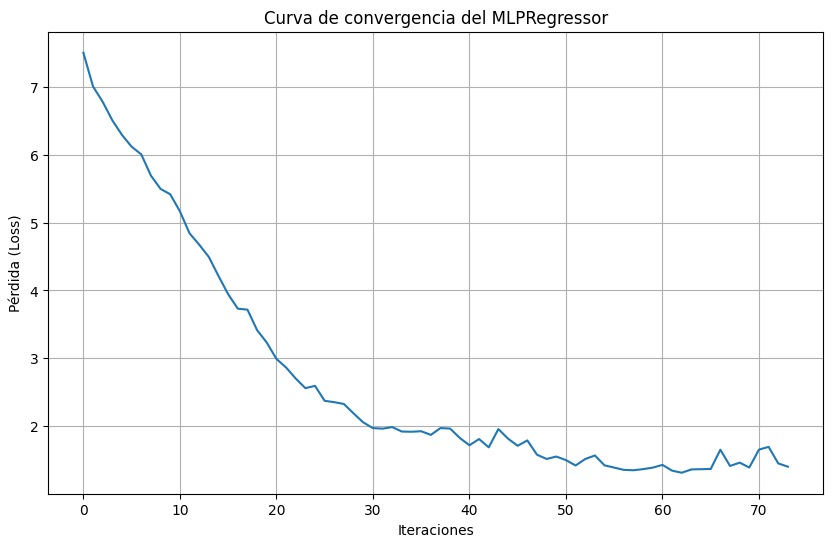

In [40]:
best_mlp = grid_search.best_estimator_.named_steps['mlp']
best_mlp
import matplotlib.pyplot as plt

# Graficar la pérdida por iteración
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_)
plt.title("Curva de convergencia del MLPRegressor")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida (Loss)")
plt.grid(True)
plt.show()

In [ ]:
# Ajustar modelo MLPRegressor
regr = MLPRegressor(
    hidden_layer_sizes=(100,),  # Una capa oculta de 100 neuronas
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    max_iter=5000,
    random_state=1
).fit(xTrainScaled, yTrain)

# --- Prueba ---
# Seleccionar todas las columnas de precipitación y eliminar filas con NaN
xTest = filtered_iqr_dataset[precip_cols].dropna()
xTestScaled = scaler.transform(xTest.values)

# Mostrar resumen
print(xTest.describe())
print(xTestScaled[:10])

e:\074-Diego Rengifo 2025\datasience\precipitacion\bigdata\bigdata\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


       precipitation_1  precipitation_2  precipitation_3  precipitation_4  \
count     19874.000000     19874.000000     19874.000000     19874.000000   
mean          0.833847         0.876252         0.874318         0.958533   
std           2.128434         2.222971         2.193745         2.414138   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.002047         0.023236         0.024952         0.062500   
50%           0.187500         0.187500         0.187500         0.250000   
75%           0.716718         0.750000         0.750000         0.823516   
max          53.250000        59.500000        58.812500        55.125000   

       precipitation_5  precipitation_6  precipitation_7  precipitation_8  \
count     19874.000000     19874.000000     19874.000000     19874.000000   
mean          0.991333         1.033761         1.175019         1.183846   
std           2.539463         2.605222         2.896215         3.015487  

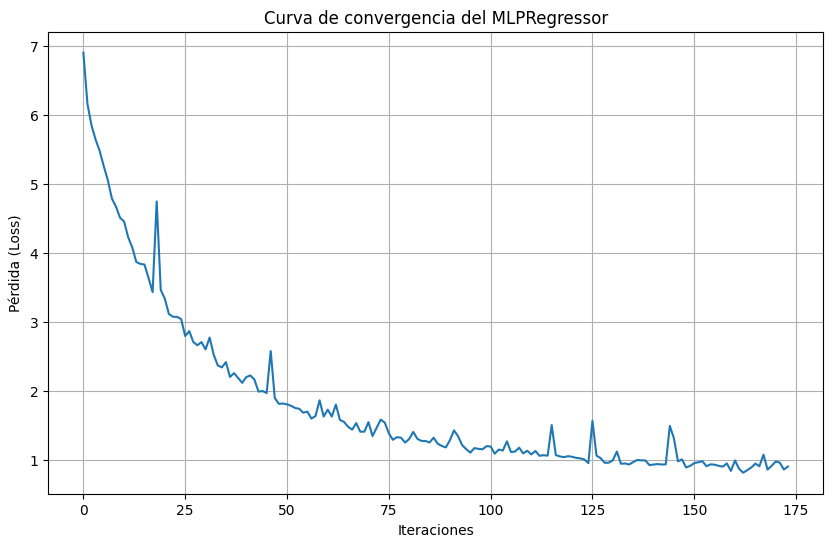

In [21]:
import matplotlib.pyplot as plt

# Graficar la pérdida por iteración
plt.figure(figsize=(10, 6))
plt.plot(regr.loss_curve_)
plt.title("Curva de convergencia del MLPRegressor")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida (Loss)")
plt.grid(True)
plt.show()

In [22]:
'''from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd


def train_and_evaluate_model(df, target_column, test_size=0.2, hidden_layers=(100,), max_iter=5000, random_state=42):
    """
    Entrena y evalúa un modelo MLPRegressor sobre un DataFrame dado.

    Args:
        df (pd.DataFrame): DataFrame con las variables.
        target_column (str): Nombre de la columna objetivo.
        test_size (float): Proporción para conjunto de prueba.
        hidden_layers (tuple): Estructura de capas ocultas.
        max_iter (int): Número máximo de iteraciones.
        random_state (int): Semilla para replicabilidad.

    Returns:
        dict: Métricas del modelo.
        object: Modelo entrenado.
        np.ndarray: Predicciones sobre conjunto de prueba.
        pd.DataFrame: Conjunto de prueba con predicciones añadidas.
    """
    
    # Eliminar filas con NaN
    df_clean = df.dropna()
    
    # Separar variables independientes y dependiente
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column].values.flatten()

    # División en train y test
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Escalar datos
    scaler = StandardScaler().fit(xTrain)
    xTrainScaled = scaler.transform(xTrain)
    xTestScaled = scaler.transform(xTest)

    # Crear y entrenar modelo
    regr = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        max_iter=max_iter,
        random_state=random_state
    )
    regr.fit(xTrainScaled, yTrain)

    # Predicción
    yPred = regr.predict(xTestScaled)

    # Métricas
    metrics = {
        "MAE": mean_absolute_error(yTest, yPred),
        "MSE": mean_squared_error(yTest, yPred),
        "RMSE": mean_squared_error(yTest, yPred, squared=False),
        "R2": r2_score(yTest, yPred)
    }

    # Crear DataFrame con predicciones para análisis posterior
    results_df = xTest.copy()
    results_df[target_column] = yTest
    results_df["predicted_" + target_column] = yPred

    return metrics, regr, yPred, results_df
'''


'from sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.neural_network import MLPRegressor\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\nimport pandas as pd\n\n\ndef train_and_evaluate_model(df, target_column, test_size=0.2, hidden_layers=(100,), max_iter=5000, random_state=42):\n    """\n    Entrena y evalúa un modelo MLPRegressor sobre un DataFrame dado.\n\n    Args:\n        df (pd.DataFrame): DataFrame con las variables.\n        target_column (str): Nombre de la columna objetivo.\n        test_size (float): Proporción para conjunto de prueba.\n        hidden_layers (tuple): Estructura de capas ocultas.\n        max_iter (int): Número máximo de iteraciones.\n        random_state (int): Semilla para replicabilidad.\n\n    Returns:\n        dict: Métricas del modelo.\n        object: Modelo entrenado.\n        np.ndarray: Predicciones sobre conjunto de prueba.\n        

In [41]:
from sklearn.model_selection import cross_val_score

# Validación cruzada de 5 pliegues (k-fold)
scores = cross_val_score(
    best_mlp, xTrainScaled, yTrain, scoring='neg_mean_squared_error', cv=5
)

print("Cross-validation MSE scores:", -scores)
print("Cross-validation MSE promedio:", -scores.mean())


Cross-validation MSE scores: [23.50390879 14.91632469 12.3141479  15.15979132 11.96950737]
Cross-validation MSE promedio: 15.572736012795554


- Guardar y reutilizar el modelo (opcional)

In [24]:
'''import joblib

# Guardar modelo
joblib.dump(regr, 'mlp_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Cargar luego
# regr = joblib.load('mlp_model.pkl')
'''

"import joblib\n\n# Guardar modelo\njoblib.dump(regr, 'mlp_model.pkl')\njoblib.dump(scaler, 'scaler.pkl')\n\n# Cargar luego\n# regr = joblib.load('mlp_model.pkl')\n"

In [25]:
# --- Predicción ---
yPredict = regr.predict(xTestScaled)
print(yPredict[:10])

[ 0.50386536 -0.60440564 -1.8500547   0.88170248  4.42588307  0.98192989
  0.60982363  0.51847685  1.01144585  1.23247904]


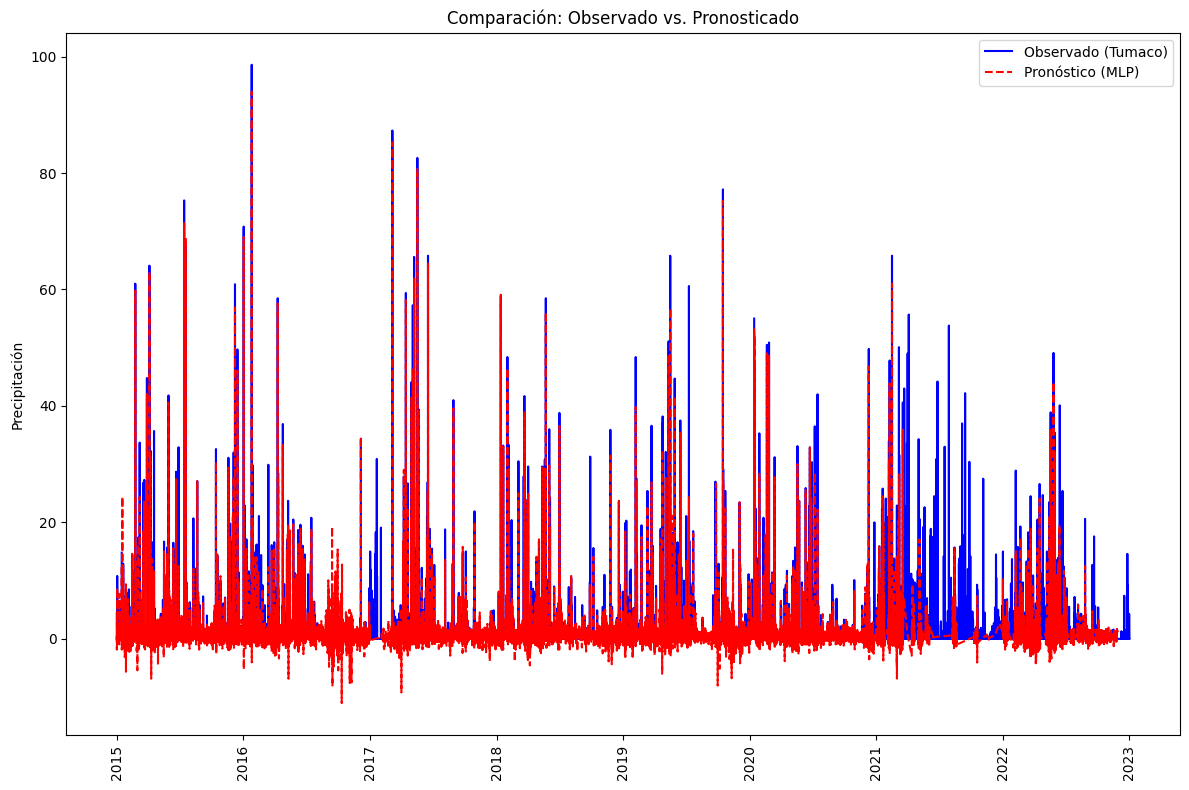

In [26]:
# --- Visualización de comparación ---
fig, ax = plt.subplots(figsize=(12, 8), sharex=True, sharey=True)
ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label='Observado (Tumaco)', color='blue')
ax.plot(xTest.index, yPredict, label='Pronóstico (MLP)', color='red', linestyle='--')
ax.set_title('Comparación: Observado vs. Pronosticado')
ax.set_ylabel('Precipitación')
ax.legend()
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [27]:
'''from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(filtered_dataset.loc[xTest.index, 'value'], yPredict))
print("RMSE:", np.sqrt(mean_squared_error(filtered_dataset.loc[xTest.index, 'value'], yPredict)))
print("R²:", r2_score(filtered_dataset.loc[xTest.index, 'value'], yPredict))
'''

'from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\n\nprint("MAE:", mean_absolute_error(filtered_dataset.loc[xTest.index, \'value\'], yPredict))\nprint("RMSE:", np.sqrt(mean_squared_error(filtered_dataset.loc[xTest.index, \'value\'], yPredict)))\nprint("R²:", r2_score(filtered_dataset.loc[xTest.index, \'value\'], yPredict))\n'

C:\Users\drengifo\AppData\Local\Temp\ipykernel_67888\2247674629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_iqr_dataset['imputados'] = np.nan


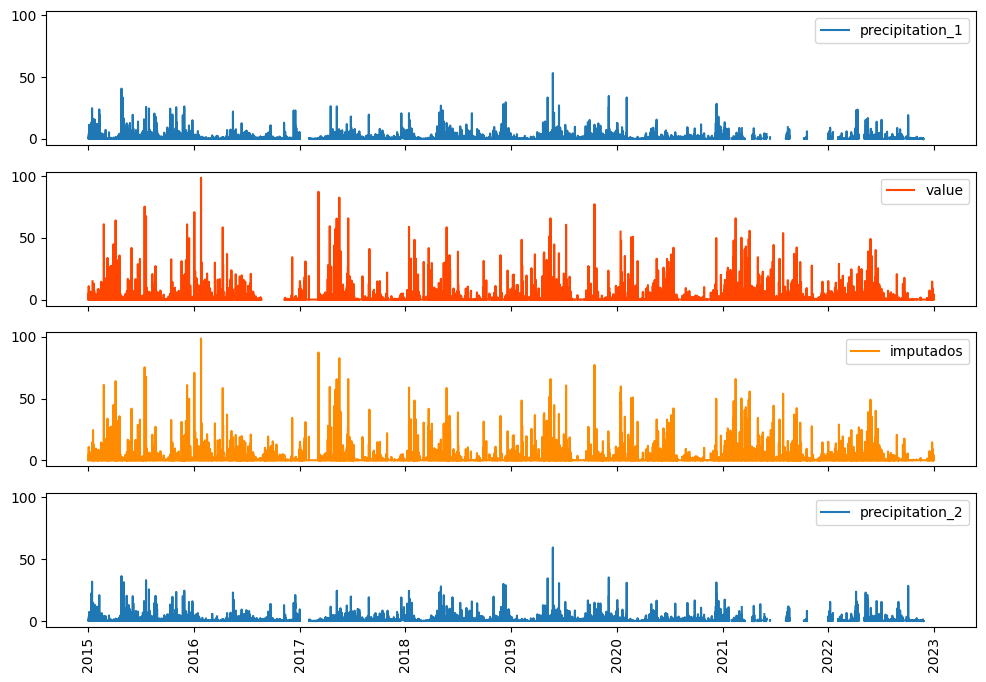

In [28]:
# Crear la nueva columna
filtered_iqr_dataset['imputados'] = np.nan

# Crear máscara
missing_mask = (
    filtered_iqr_dataset['value'].isna() &
    filtered_iqr_dataset[columns_for_model].notna().all(axis=1)
)

# Transformar y predecir
to_impute = filtered_iqr_dataset.loc[missing_mask, columns_for_model]
to_impute_scaled = scaler.transform(to_impute)
predicted_values = regr.predict(to_impute_scaled)
predicted_values = np.where(predicted_values < 0, 0, predicted_values)
filtered_iqr_dataset.loc[missing_mask, 'imputados'] = predicted_values

# Copiar los valores originales donde existen
filtered_iqr_dataset.loc[filtered_iqr_dataset['value'].notna(), 'imputados'] = filtered_iqr_dataset['value']

#show original and filled values
fig, axs=plt.subplots(4,1,figsize=(12,8),sharex=True,sharey=True)
axs[0].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['precipitation_1'],label='precipitation_1')
axs[0].legend()
axs[1].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['value'],label='value',color='orangered')
axs[1].legend()
axs[2].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['imputados'],label='imputados',color='darkorange')
axs[2].legend()
axs[3].plot(filtered_iqr_dataset.index,filtered_iqr_dataset['precipitation_2'],label='precipitation_2')
axs[3].legend()
plt.xticks(rotation='vertical')
plt.show()

In [29]:
# Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(filtered_iqr_dataset.isnull().sum())


Reporte de datos NaN por columna:
value                 864
precipitation_1      3504
precipitation_2      3504
precipitation_3      3504
precipitation_4      3504
                     ... 
precipitation_897    3504
precipitation_898    3504
precipitation_899    3504
precipitation_900    3504
imputados               2
Length: 902, dtype: int64


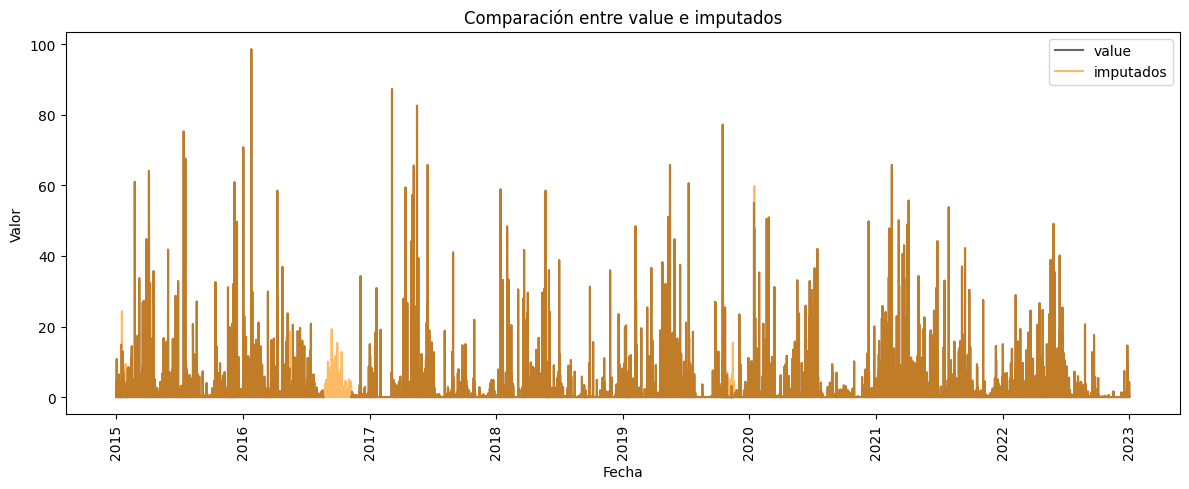

In [30]:
# Mostrar solo 'value' e 'imputados' con transparencia
plt.figure(figsize=(12, 5))
plt.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label='value', color='black', alpha=0.6)
plt.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['imputados'], label='imputados', color='darkorange', alpha=0.6)
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Comparación entre value e imputados')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.tight_layout()
plt.show()


In [31]:
from graphics_utils.go import multi_line

fig=multi_line(original=filtered_iqr_dataset['value'], imputada=filtered_iqr_dataset['imputados'])
fig.show()

In [32]:
'''import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = filtered_iqr_dataset.corr()

# Crear el mapa de calor
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

# Título y ajustes
plt.title("Mapa de Correlación")
plt.tight_layout()
plt.show()
'''

'import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calcular la matriz de correlación\ncorrelation_matrix = filtered_iqr_dataset.corr()\n\n# Crear el mapa de calor\nplt.figure(figsize=(6, 4))\nsns.heatmap(correlation_matrix, annot=True, cmap=\'coolwarm\', vmin=-1, vmax=1, fmt=".2f")\n\n# Título y ajustes\nplt.title("Mapa de Correlación")\nplt.tight_layout()\nplt.show()\n'

# validacion de pronostico 2023

In [33]:
# --- Predicción ---
yPredict = regr.predict(xTestScaled)
print(yPredict[:10])

# 1. Valores originales sin escalar (serie completa hasta 2023)
# Debe tener frecuencia fija de 3H y estar limpia
# Asegúrate de que el índice sea de tipo datetime
msweb_serie_with_nans.index = pd.to_datetime(msweb_serie_with_nans.index)
xTrainScaledForecast = msweb_serie_with_nans.loc['2023']  # serie original sin escalar

# 2. Últimos N valores de la serie para generar los primeros lags
N_LAGS = xTrainScaled.shape[1]  # número de columnas usadas como input
últimos_valores = precip_series.dropna().values[-N_LAGS:].tolist()

# 3. Crear fechas objetivo del forecast
n_horas = int((365 * 24) / 3)  # para 3 horas: 2920 pasos
fechas_2024 = pd.date_range(start='2023-01-01', periods=n_horas, freq='3H')

# 4. Forecast recursivo
predicciones = []

for _ in range(n_horas):
    # Tomar los últimos N valores
    input_vals = np.array(últimos_valores[-N_LAGS:]).reshape(1, -1)
    
    # Escalar
    input_scaled = scaler.transform(input_vals)
    
    # Predecir
    y_pred = regr.predict(input_scaled)[0]
    
    # Guardar predicción
    predicciones.append(y_pred)
    
    # Añadir al historial para la siguiente predicción
    últimos_valores.append(y_pred)  # usamos el valor predicho como siguiente lag


[ 0.50386536 -0.60440564 -1.8500547   0.88170248  4.42588307  0.98192989
  0.60982363  0.51847685  1.01144585  1.23247904]


NameError: name 'precip_series' is not defined

In [ ]:
N_LAGS

900

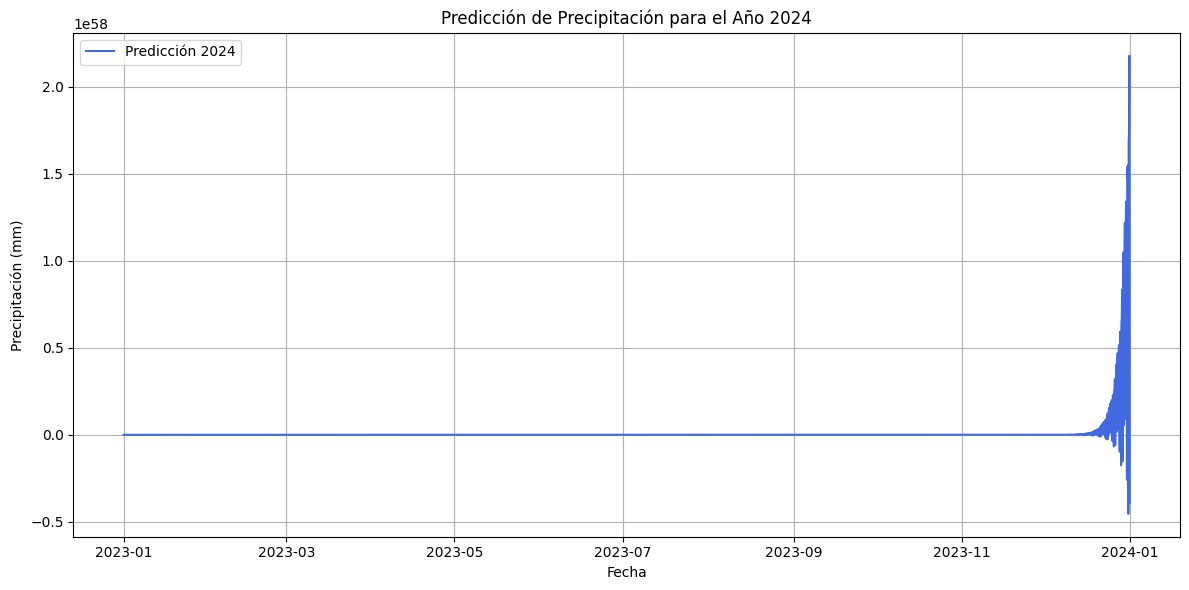

In [ ]:
pred_2024 = pd.DataFrame({'Predicción': predicciones}, index=fechas_2024)
pred_2024.index = pd.to_datetime(pred_2024.index)

# Crear gráfico
plt.figure(figsize=(12, 6))
plt.plot(pred_2024.index, pred_2024['Predicción'], label='Predicción 2024', color='royalblue')

# Formato del gráfico
plt.title('Predicción de Precipitación para el Año 2024')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()



¿Valores nulos restantes? 0


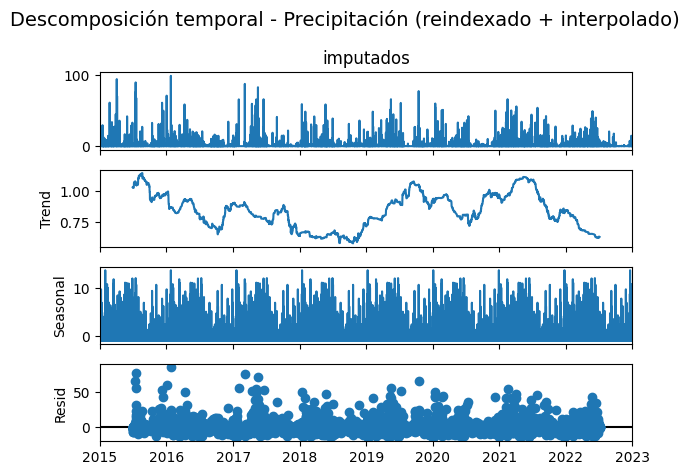

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Selecciona la columna
precip_clean = filtered_iqr_dataset['imputados'].copy()

# 2. Convierte el índice a datetime si no lo es
precip_clean.index = pd.to_datetime(precip_clean.index)

# 3. Reindexar con frecuencia completa para evitar huecos ocultos
full_index = pd.date_range(start=precip_clean.index.min(), end=precip_clean.index.max(), freq='3h')
precip_clean = precip_clean.reindex(full_index)

# 4. Interpola para evitar NaNs
precip_clean = precip_clean.interpolate(method='linear')

# 5. Confirmar limpieza
print("¿Valores nulos restantes?", precip_clean.isna().sum())

# 6. Descomposición (usamos period=8 para ciclo diario en datos 3H)
decomposition = seasonal_decompose(precip_clean, model='additive', period=8*30*12)
decomposition.plot()
plt.suptitle("Descomposición temporal - Precipitación (reindexado + interpolado)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import plotly.graph_objects as go

# 1. Selección de la columna
precip_clean = filtered_iqr_dataset['imputados'].copy()

# 2. Conversión del índice a datetime
precip_clean.index = pd.to_datetime(precip_clean.index)

# 3. Reindexar con frecuencia completa
full_index = pd.date_range(start=precip_clean.index.min(), end=precip_clean.index.max(), freq='3h')
precip_clean = precip_clean.reindex(full_index)

# 4. Interpolación para NaNs
precip_clean = precip_clean.interpolate(method='linear')

# 5. Verificar valores nulos
print("¿Valores nulos restantes?", precip_clean.isna().sum())

# 6. Descomposición
decomposition = seasonal_decompose(precip_clean, model='additive', two_sided=True,period=8*28*18)

# 7. Visualización con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.observed, name='Observed'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.trend, name='Trend'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.seasonal, name='Seasonal'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.resid, name='Residual'))

fig.update_layout(
    title='Descomposición Temporal - Precipitación (Plotly)',
    xaxis_title='Fecha',
    yaxis_title='Valor',
    height=600,
    legend_title='Componentes',
    template='plotly_white'
)

fig.show()


¿Valores nulos restantes? 0
